# ResNet

[Paper here](https://arxiv.org/pdf/1512.03385)


In [39]:
from rich import print
from tqdm.notebook import tqdm
from typing import List
%load_ext rich


The rich extension is already loaded. To reload it, use:
  %reload_ext rich


In [82]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torchvision.utils import make_grid
import mlflow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.enable_system_metrics_logging()


In [16]:
# Hyperparameters

BATCH_SIZE = 64
N_EPOCHS = 30
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
N_CLASSES = 10

## Load the dataset


In [102]:
true_labels = [
    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm",
]


In [83]:
train_dataset = CIFAR100(
    root="./data/", download=True, train=True, transform=transforms.ToTensor()
)
test_dataset = CIFAR100(
    root="./data/", download=True, train=False, transform=transforms.ToTensor()
)

100%|██████████| 169001437/169001437 [00:02<00:00, 60811081.90it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data/
Files already downloaded and verified


In [84]:
mean_pixel_train = train_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_train = train_dataset.data.std(axis=(0, 1, 2)) / 255

mean_pixel_test = test_dataset.data.mean(axis=(0, 1, 2)) / 255
std_pixel_test = test_dataset.data.std(axis=(0, 1, 2)) / 255

(mean_pixel_train, std_pixel_train), (mean_pixel_test, std_pixel_test)



(
    (array([0.50707516, 0.48654887, 0.44091784]), array([0.26733429, 0.25643846, 0.27615047])),
    (array([0.50879641, 0.48739301, 0.44194221]), array([0.26825157, 0.25736374, 0.27709577]))
)

In [85]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean_pixel_train, std_pixel_train),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean_pixel_test, std_pixel_test),
    ]
)

In [86]:
def reverse_transform(x, train=True):
    mean_pixel, std_pixel = (
        mean_pixel_train if train else mean_pixel_test,
        std_pixel_train if train else std_pixel_test,
    )

    x = x * torch.tensor(std_pixel).view(3, 1, 1) + torch.tensor(mean_pixel).view(
        3, 1, 1
    )

    x = transforms.ToPILImage()(x)

    return x

In [93]:
full_train_dataset = CIFAR100(
    root="./data/", download=True, train=True, transform=train_transform
)

test_dataset = CIFAR100(
    root="./data/", download=True, train=False, transform=test_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [94]:
# Calculate the sizes for training and validation datasets (70-30 split)
train_size = int(0.7 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Split the full training dataset into training and validation datasets
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


In [95]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [96]:
len(train_loader), len(val_loader), len(test_loader)

(547, 235, 157)

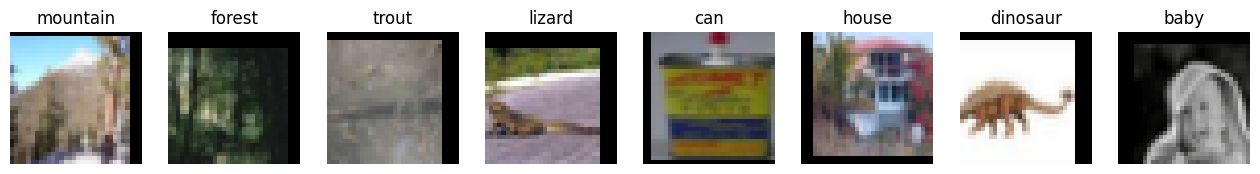

In [103]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))
indices = torch.randperm(len(train_dataset))[:8]
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = reverse_transform(img, train=True)
    axs[i].imshow(img)
    axs[i].set_title(f"{true_labels[label]}")
    axs[i].axis("off")

plt.show()


## Build the architecture


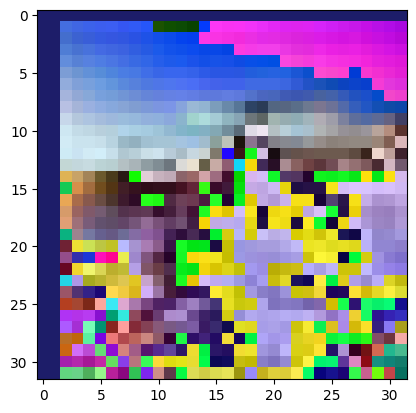

torch.Size([3, 32, 32])

59 pine_tree

In [104]:
sample_image, sample_label = train_loader.dataset[1]
plt.imshow(transforms.ToPILImage()(sample_image))
plt.show()
print(sample_image.shape)
print(sample_label, true_labels[sample_label])

In [40]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, first_stride: int = 1):
        super().__init__()

        self.left = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=first_stride,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=out_channels),
        )

        if first_stride > 1:
            self.right = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=first_stride,
                    bias=False,
                ),
                nn.BatchNorm2d(num_features=out_channels),
            )
        else:
            assert (
                in_channels == out_channels
            ), "in_channels must be equal to out_channels"
            self.right = nn.Identity()

    def forward(self, x):
        left = self.left(x)
        right = self.right(x)
        return F.relu(left + right)


In [67]:
class ResNet(nn.Module):
    def __init__(self, n_classes: int = 10, n_blocks: int = 5, debug: bool = False):
        super().__init__()

        self.debug = debug
        self.n_blocks = n_blocks
        self.n_classes = n_classes

        self.layer1 = nn.Sequential(
            # B x 3 x 32 x 32 -> B x 16 x 32 x 32
            nn.Conv2d(3, 16, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=16),
        )

        # B x 16 x 32 x 32 -> B x 16 x 32 x 32
        self.residual_layer1 = nn.Sequential(
            *[ResidualBlock(16, 16, 1) for _ in range(self.n_blocks)]
        )

        # B x 16 x 32 x 32 -> B x 32 x 16 x 16
        self.residual_layer2 = nn.Sequential(
            ResidualBlock(16, 32, 2),
            *[ResidualBlock(32, 32, 1) for _ in range(self.n_blocks - 1)],
        )

        # B x 32 x 16 x 16 -> B x 64 x 8 x 8
        self.residual_layer3 = nn.Sequential(
            ResidualBlock(32, 64, 2),
            *[ResidualBlock(64, 64, 1) for _ in range(self.n_blocks - 1)],
        )

        # B x 64 x 8 x 8 -> B x 10
        self.out_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=self.n_classes),
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def _debug_print(self, tensor, name):
        if self.debug:
            print(f"{name}: {tensor.shape}")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._debug_print(x, "Input")
        x = self.layer1(x)
        self._debug_print(x, "Layer1")
        x = self.residual_layer1(x)
        self._debug_print(x, "ResidualLayer1")
        x = self.residual_layer2(x)
        self._debug_print(x, "ResidualLayer2")
        x = self.residual_layer3(x)
        self._debug_print(x, "ResidualLayer3")
        x = self.out_layers(x)
        self._debug_print(x, "Output")

        return x


In [76]:
model = ResNet(n_blocks=9, debug=True).to(device)
x = model(sample_image.unsqueeze(0).to(device))

Input: torch.Size([1, 3, 32, 32])

Layer1: torch.Size([1, 16, 32, 32])

ResidualLayer1: torch.Size([1, 16, 32, 32])

ResidualLayer2: torch.Size([1, 32, 16, 16])

ResidualLayer3: torch.Size([1, 64, 8, 8])

Output: torch.Size([1, 10])

In [77]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 855386

## Train the model

In [78]:
model = ResNet(n_classes=N_CLASSES, n_blocks=9, debug=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1
)

In [20]:
mlflow.set_experiment(experiment_name="vggnet")

<Experiment: artifact_location='mlflow-artifacts:/203950544768537115', creation_time=1721448495671, experiment_id='203950544768537115', last_update_time=1721448495671, lifecycle_stage='active', name='vggnet', tags={}>

In [79]:
# with mlflow.start_run() as run:
# run_id = run.info.run_id
# Log hyperparameters
# mlflow.log_params(
#     {
#         "N_EPOCHS": N_EPOCHS,
#         "LEARNING_RATE": LEARNING_RATE,
#         "BATCH_SIZE": BATCH_SIZE,
#         "Optimizer": optimizer.__class__.__name__,
#         "Loss Function": criterion.__class__.__name__,
#     }
# )

for epoch in tqdm(range(2), desc="Epochs"):
    # ---------- Training ----------
    train_loss = 0

    for batch, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        model.train()

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}")
    # mlflow.log_metric("train_loss", train_loss, step=epoch)

    # ---------- Validation ----------

    val_loss = 0
    correct = 0
    total = 0

    label_in_top_5 = 0

    # Custom evaluation metric: Label in top 5 predictions

    model.eval()
    with torch.inference_mode():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss += criterion(outputs, labels)

            top5_preds = outputs.topk(k=5, dim=-1).indices

            total += labels.size(0)
            correct += (labels == outputs.argmax(dim=-1)).sum().item()
            label_in_top_5 += (
                (labels.view(-1, 1) == top5_preds).any(dim=-1).sum().item()
            )

        val_loss /= len(val_loader)
        val_acc = correct / total
        val_top_5_error = label_in_top_5 / total
        scheduler.step(val_loss)

        print(
            f"Epoch: {epoch} | Val Loss: {val_loss:.4f} | Val Top-1 Accuracy: {val_acc:.2%} | Val Top-5 Accuracy : {val_top_5_error:.2%}"
        )

#     mlflow.log_metric("val_loss", val_loss, step=epoch)
#     mlflow.log_metric("val_acc", val_acc, step=epoch)

# mlflow.pytorch.log_model(model, "model")

Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.7930

Validation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 0 | Val Loss: 1.5694 | Val Top-1 Accuracy: 42.16% | Val Top-5 Accuracy : 90.72%

Training:   0%|          | 0/547 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.4070

Validation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch: 1 | Val Loss: 1.3348 | Val Top-1 Accuracy: 51.59% | Val Top-5 Accuracy : 93.83%

## Test the model

In [80]:
model.eval()

test_loss = 0
correct = 0
total = 0
label_in_top_3 = 0
# with mlflow.start_run(run_id=run_id):
with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        test_loss += criterion(outputs, labels)

        top3_preds = outputs.topk(k=3, dim=-1).indices

        total += labels.size(0)
        correct += (labels == outputs.argmax(dim=-1)).sum().item()
        label_in_top_3 += (labels.view(-1, 1) == top3_preds).any(dim=-1).sum()

    test_loss /= len(test_loader)
    test_acc = correct / total
    test_top_3_error = label_in_top_3 / total

print(
    f"Test Loss: {test_loss:.4f} | Test Top-1 Accuracy: {test_acc:.2%} | Test Top-3 Accuracy: {test_top_3_error:.2%}"
)

# mlflow.log_metric("test_loss", test_loss)
# mlflow.log_metric("test_acc", test_acc)

Test Loss: 1.3183 | Test Top-1 Accuracy: 51.81% | Test Top-5 Accuracy: 94.57%

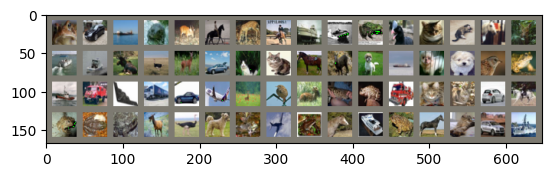

Index     Predicted Actual

0         dog       frog

1         automobileautomobile

2         airplane  ship

3         dog       frog

4         dog       deer

5         horse     horse

6         frog      deer

7         horse     horse

8         ship      ship

9         ship      ship

10        automobilefrog

11        dog       bird

12        cat       cat

13        airplane  cat

14        dog       horse

15        frog      deer

16        airplane  ship

17        ship      ship

18        deer      deer

19        bird      bird

20        horse     deer

21        automobileautomobile

22        dog       cat

23        cat       cat

24        horse     horse

25        horse     deer

26        bird      dog

27        airplane  ship

28        dog       dog

29        cat       dog

30        frog      bird

31        frog      frog

32        airplane  ship

33        automobiletruck

34        airplane  airplane

35        automobiletruck

36        automobileautomobile

37        airplane  airplane

38        bird      deer

39        airplane  bird

40        deer      deer

41        frog      cat

42        frog      frog

43        automobiletruck

44        cat       cat

45        dog       cat

46        automobileautomobile

47        dog       horse

48        frog      frog

49        frog      frog

50        frog      frog

51        horse     deer

52        airplane  bird

53        horse     dog

54        frog      frog

55        airplane  airplane

56        truck     frog

57        frog      horse

58        automobileship

59        frog      frog

60        airplane  horse

61        cat       cat

62        automobileautomobile

63        ship      ship

In [81]:
sample_test_images, sample_test_labels = next(iter(test_loader))

plt.imshow(
    reverse_transform(make_grid(sample_test_images, nrow=16, padding=8, scale_each=3))
)

plt.show()

prediction = model(sample_test_images.to(device))

predicted_labels = prediction.argmax(dim=-1).cpu().numpy()
actual_labels = sample_test_labels.cpu().numpy()

print(f"{'Index':<10}{'Predicted':<10}{'Actual':<10}")
for i, (pred, actual) in enumerate(zip(predicted_labels, actual_labels)):
    print(f"{i:<10}{true_labels[pred]:<10}{true_labels[actual]:<10}", end="\n")